In [ ]:
# Import various python packages

import iris
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation as icc
from iris.time import PartialDateTime
import iris.util as iutil

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import cartopy.crs as ccrs

import os
import warnings 

import cartopy.io.shapereader as shpreader

import cartopy.feature as cfeature
import matplotlib.path as mpath
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D

from scipy.optimize import minimize, LinearConstraint, Bounds

from pathlib import Path
import requests

import pickle


warnings.filterwarnings('ignore') 

In [2]:
import sys
sys.path.append('..')

from Cube_Functions import *
from Plot_Functions import *
from Climate_Functions import *
from Stats_Functions import *
print('Finished loading libraries and functions')

#clean up namespace
del sys

Finished loading libraries and functions


In [3]:
experiment = 'lig127k'
control = 'piControl'

root_path = '/gws/nopw/j04/pmip4_vol1/public/matt/data/'

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

var = 'tas'



In [4]:

models_with_files = []
#for every folder in the root path
exp_matches = None
con_matches = None
for folder in os.listdir(root_path):
    #if the folder is a directory and contains the experiment
    print(folder)
    if os.path.isdir(os.path.join(root_path, folder, experiment)):
        #print(f'Found {experiment} folder: {folder}')
        #check if there's a file like *_tas_*.nc in the experiment folder
        exp_path = os.path.join(root_path, folder, experiment)
        exp_matches = list(Path(exp_path).glob("tas_*.nc"))
        if exp_matches:
            print(f"Found {experiment}:", len(exp_matches), " files")
        else:
            print("No matching files")
    if os.path.isdir(os.path.join(root_path, folder, control)):
        #print(f'Found {experiment} folder: {folder}')
        #check if there's a file like *_tas_*.nc in the experiment folder
        con_path = os.path.join(root_path, folder, control)
        con_matches = list(Path(con_path).glob("tas_*.nc"))
        if con_matches:
            print(f"Found {control}:", len(con_matches), " files")
        else:
            print("No matching files")
    if exp_matches and con_matches:
        models_with_files.append(folder)
        print(f"Found both {experiment} and {control} for model: {folder}")
print(f"Models with files: {models_with_files}")

.ipynb_checkpoints
ACCESS-ESM1-5
Found lig127k: 1  files
Found piControl: 1  files
Found both lig127k and piControl for model: ACCESS-ESM1-5
CESM2
Found lig127k: 1  files
Found piControl: 1  files
Found both lig127k and piControl for model: CESM2
CNRM-CM6-1
Found lig127k: 1  files
Found piControl: 1  files
Found both lig127k and piControl for model: CNRM-CM6-1
EC-Earth3
Found lig127k: 1  files
Found piControl: 1  files
Found both lig127k and piControl for model: EC-Earth3
EC-Earth3-LR
No matching files
No matching files
FGOALS-f3-L
Found lig127k: 1  files
Found piControl: 1  files
Found both lig127k and piControl for model: FGOALS-f3-L
FGOALS-g3
Found lig127k: 1  files
Found piControl: 1  files
Found both lig127k and piControl for model: FGOALS-g3
HadGEM3-GC31-LL
Found lig127k: 1  files
Found piControl: 1  files
Found both lig127k and piControl for model: HadGEM3-GC31-LL
INM-CM4-8
Found lig127k: 1  files
Found piControl: 1  files
Found both lig127k and piControl for model: INM-CM4-8
IP

In [5]:

models = ['ACCESS-ESM1-5', 
          #'CESM2', #aap245 siconc looks off 
          'CNRM-CM6-1', 
          'EC-Earth3', 
          'FGOALS-f3-L',
          'FGOALS-g3',
          'HadGEM3-GC31-LL', 
          #'INM-CM4-8', No lig12k siconc 
          'IPSL-CM6A-LR', 
          'NESM3',
            #, 'NorESM1-F' # siconc is missing from the data archive entirely
            # , 'NorESM2-LM' # missing siconc data (file is there but all zeros)
            ] 





#---------------#
#Models that have tas files for lig127k on ESGF:
#N/A means they don't have siconc for ssp245
# ACCESS-ESM1-5	2
# AWI-ESM-1-1-LR	#N/A
# CESM2	5
# CNRM-CM6-1	10
# EC-Earth3-LR	#N/A
# FGOALS-f3-L	19
# FGOALS-g3	20
# HadGEM3-GC31-LL	24
# INM-CM4-8	25
# IPSL-CM6A-LR	27
# NESM3	33
# NorESM1-F	#N/A
# NorESM2-LM	34

#------------
print(models)

['ACCESS-ESM1-5', 'CNRM-CM6-1', 'EC-Earth3', 'FGOALS-f3-L', 'FGOALS-g3', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'NESM3']


In [6]:

con = iris.Constraint(latitude=lambda lat: 59.5 <= lat <= 90)

time_con = iris.Constraint(year=lambda y:np.logical_and(y>=2035,y<2045))  #time_constraint. Not used anywhere yet.

ocean_shp_reader = shpreader.Reader(shpreader.natural_earth(resolution="110m", category="physical", name="ocean"))
ocean_list = []
for ocean in ocean_shp_reader.records():
    ocean_list.append(ocean.geometry)
ocean_shp = ocean_list[1]

shape = ocean_shp

shape = None

In [7]:
#Proxy data from https://doi.org/10.5194/cp-19-883-2023

point_lats = [55,55,61,68,68,70,73.33,63,64,66,67,67,67.5,69,69,71.75,76.35,73,73,75,76.4]
point_lons = [18, -3, 152.5, 80, 160, -72.5, 141.5, -66, -150, -69.2, -160, -62, 172.08, -151, -133, -23, -68.3, -25, -38, -42, -44.8]
point_vals = [3.4,2.4,6.4,5.4,6.4,4.9,4.9,5.4,1.4,4.9,1.9,5.9,3.4,1.9,2.4,5.4,4.4,5.4,5.4,5.4,8]
point_markers = ['^','^','^','^','^','^','^','d','d','d','d','d','d','d','d','o','o','*','*','*','*']
point_sizes=[30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,50,50,50,50]
point_sds = [0.5,0.5,2,2,2,0.5,0.5,0.5,1,0.5,1.5,1.5,1,1.5,0.5,0.5,0.5,0.5,0.5,0.5,4]


#combine proxy data into a dictionary
proxy_data = {
    'point_lats': point_lats,
    'point_lons': point_lons,
    'point_vals': point_vals,
    'point_markers': point_markers,
    'point_sizes': point_sizes,
    'point_sds': point_sds
}

#create a dict of the proxy values in the same format as proxy_model_data
proxy_values_dict = {}
for i in range(len(point_lats)):
    lat = point_lats[i]
    lon = point_lons[i]
    val = point_vals[i]
    proxy_values_dict[(lat,lon)] = val
print('Finished creating proxy values dictionary')

Finished creating proxy values dictionary


In [8]:
def create_dict(simulation):
    var_dict={}
    for model in models:
        print('Processing '+model)
        var_dict[model] = {}
        path = create_path(model, simulation, var, root_path)
        cube = get_cube(path, var, con, shape)
        monthly_data = get_monthly_data(cube, 'MEAN')
        var_dict[model]['monthly_data'] = monthly_data
        var_dict[model]['cube'] = cube

        #create cube of monthly means
        monthly_means = []
        for month in range(1,13):
            month_con = iris.Constraint(month_number=month)
            month_cube = cube.extract(month_con)
            month_mean = month_cube.collapsed('time', iris.analysis.MEAN)
            monthly_means.append(month_mean)
        var_dict[model]['monthly_means'] = monthly_means
    return var_dict


In [9]:

def harmonise_lat_lon_bounds(c1, c2, tol=1e-10, coords=("latitude", "longitude")):
    """
    Make coordinate bounds consistent between two Iris cubes for the given coords.

    Strategy per coord:
      1) Require coord points to match (within tol) — otherwise raise (needs regridding/alignment).
      2) If one cube has bounds and the other doesn't, copy bounds across.
      3) If both have bounds but differ (within tol), overwrite c2 bounds with c1 bounds.

    Parameters
    ----------
    c1, c2 : iris.cube.Cube
        Cubes to be made compatible for arithmetic.
    tol : float
        Absolute tolerance for np.allclose comparisons.
    coords : tuple[str]
        Coordinate names to harmonise (default: ('latitude','longitude')).
    """
    for cname in coords:
        coord1 = c1.coord(cname)
        coord2 = c2.coord(cname)

        # Check points match
        if coord1.shape != coord2.shape or not np.allclose(coord1.points, coord2.points, atol=tol, rtol=0):
            raise ValueError(
                f"Coordinate points differ for '{cname}' (shapes {coord1.shape} vs {coord2.shape}). "
                "Regrid/align before arithmetic."
            )

        b1 = coord1.bounds
        b2 = coord2.bounds

        # Nothing to do
        if b1 is None and b2 is None:
            continue

        # Copy bounds if missing on one side
        if b1 is None and b2 is not None:
            coord1.bounds = b2.copy()
            continue

        if b2 is None and b1 is not None:
            coord2.bounds = b1.copy()
            continue

        # Both have bounds: reconcile if different
        if not np.allclose(b1, b2, atol=tol, rtol=0):
            coord2.bounds = b1.copy()


In [10]:
experiment_var_dict = create_dict(experiment)
control_var_dict = create_dict(control)


Processing ACCESS-ESM1-5
Processing CNRM-CM6-1
Processing EC-Earth3
Processing FGOALS-f3-L
Processing FGOALS-g3
Processing HadGEM3-GC31-LL
Processing IPSL-CM6A-LR
Processing NESM3
Processing ACCESS-ESM1-5
Processing CNRM-CM6-1
Processing EC-Earth3
Processing FGOALS-f3-L
Processing FGOALS-g3
Processing HadGEM3-GC31-LL
Processing IPSL-CM6A-LR
Processing NESM3


In [11]:

anomaly_var_dict = {}
for model in models:
    print('Calculating anomalies for '+model)
    anomaly_var_dict[model] = {}
    experiment_monthly_data = experiment_var_dict[model]['monthly_data']
    control_monthly_data = control_var_dict[model]['monthly_data']
    anomaly_monthly_data = experiment_monthly_data - control_monthly_data
    anomaly_var_dict[model]['monthly_data'] = anomaly_monthly_data

    experiment_monthly_means = experiment_var_dict[model]['monthly_means']
    control_monthly_means = control_var_dict[model]['monthly_means']
    anomaly_monthly_means = []
    for month in range(12):
        e = experiment_monthly_means[month]
        c = control_monthly_means[month]

        harmonise_lat_lon_bounds(e, c)

        anomaly_month_mean = e - c
        anomaly_monthly_means.append(anomaly_month_mean)
    anomaly_var_dict[model]['monthly_means'] = anomaly_monthly_means
    jun_cube = anomaly_var_dict[model]['monthly_means'][5]
    jul_cube = anomaly_var_dict[model]['monthly_means'][6]
    aug_cube = anomaly_var_dict[model]['monthly_means'][7]
    summer_cube = (jun_cube + jul_cube + aug_cube) / 3.0
    anomaly_var_dict[model]['summer_mean'] = summer_cube

    model_vals = []
    anomaly_var_dict[model]['point_vals'] = {}
    for i in range(len(point_lats)):
        lat = point_lats[i]
        lon = point_lons[i]
        model_cube = anomaly_var_dict[model]['summer_mean'].copy()
        model_point_cube = model_cube.interpolate([('latitude', lat), ('longitude', lon)], iris.analysis.Linear())
        model_point_val = model_point_cube.data.item()
        #model_vals.append(model_point_val)
        anomaly_var_dict[model]['point_vals'][(lat,lon)] = model_point_val
    
print('Finished calculating anomalies')



Calculating anomalies for ACCESS-ESM1-5
Calculating anomalies for CNRM-CM6-1
Calculating anomalies for EC-Earth3
Calculating anomalies for FGOALS-f3-L
Calculating anomalies for FGOALS-g3
Calculating anomalies for HadGEM3-GC31-LL
Calculating anomalies for IPSL-CM6A-LR
Calculating anomalies for NESM3
Finished calculating anomalies


In [12]:
#reformat point values into a dictionary of model: [list of point values]
model_point_dict = {}
for model in models:
    model_point_dict[model] = list(anomaly_var_dict[model]['point_vals'].values())

proxy_point_vals = list(point_vals)

print('Finished creating model point data dictionary')

Finished creating model point data dictionary


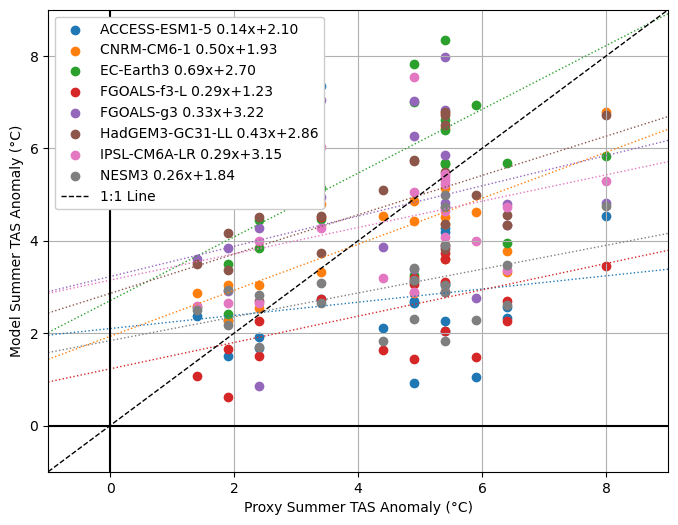

In [13]:
#for each model, plot the point_vals vs the proxy values
fig = plt.figure(figsize=(8,6))
for model in models:
    model_point_vals = model_point_dict[model]
    
    m, b = np.polyfit(proxy_point_vals, model_point_vals, 1)
    x = np.array([-1,9])
    y = m * x + b

    plt.scatter(proxy_point_vals, model_point_vals, label=f'{model} {m:.2f}x+{b:.2f}')
    plt.plot(x, y, linestyle=':', linewidth=1)#, label=f'{model} Fit')

plt.xlabel('Proxy Summer TAS Anomaly (°C)')
plt.ylabel('Model Summer TAS Anomaly (°C)')
plt.axhline(0, color='k', linestyle='-', linewidth=1.5)
plt.axvline(0, color='k', linestyle='-', linewidth=1.5)
#make sure axes are equal
plt.xlim(-1,9)
plt.ylim(-1,9)

#plot 1:1 line
plt.plot([-1,9], [-1,9], color='k', linestyle='--', linewidth=1, label='1:1 Line')

# #for each model, plot linear regression line
# for model in models:
#     model_point_vals = []
#     proxy_point_vals = []
#     for i in range(len(point_lats)):
#         lat = point_lats[i]
#         lon = point_lons[i]
#         model_val = anomaly_var_dict[model]['point_vals'][(lat,lon)]
#         proxy_val = proxy_values_dict[(lat,lon)]
#         model_point_vals.append(model_val)
#         proxy_point_vals.append(proxy_val)
#     #linear regression
#     m, b = np.polyfit(proxy_point_vals, model_point_vals, 1)
#     x = np.array([-1,9])
#     y = m * x + b
#     plt.plot(x, y, linestyle=':', linewidth=1)#, label=f'{model} Fit')

plt.legend(loc='upper left', framealpha=1)
plt.grid()
plt.show()


In [14]:
def calculate_rmse(model_point_vals, proxy_point_vals):
    model_point_vals = np.array(model_point_vals)
    proxy_point_vals = np.array(proxy_point_vals)
    rms_error = np.sqrt(np.mean((model_point_vals - proxy_point_vals)**2))
    return rms_error

In [15]:
#for each model, calculate the RMSE between the model point vals and the proxy point vals
rmse_dict = {}
for model in models:
    model_point_vals = model_point_dict[model]
    model_point_vals = np.array(model_point_vals)
    proxy_point_vals = np.array(proxy_point_vals)
    rmse = calculate_rmse(proxy_point_vals, model_point_vals)
    rmse_dict[model] = rmse
    print(f'Model: {model}, RMSE: {rmse:.2f} °C')

Model: ACCESS-ESM1-5, RMSE: 2.68 °C
Model: CNRM-CM6-1, RMSE: 1.34 °C
Model: EC-Earth3, RMSE: 2.62 °C
Model: FGOALS-f3-L, RMSE: 2.51 °C
Model: FGOALS-g3, RMSE: 1.94 °C
Model: HadGEM3-GC31-LL, RMSE: 1.40 °C
Model: IPSL-CM6A-LR, RMSE: 1.67 °C
Model: NESM3, RMSE: 2.14 °C


In [16]:


def fit_weights_rmse(model_point_dict, proxy_point_vals, nonnegative=True, sum_to_one=True):
    # --- Build X (N x M) and y (N,) ---
    model_names = list(model_point_dict.keys())
    X = np.column_stack([np.asarray(model_point_dict[m], dtype=float) for m in model_names])
    y = np.asarray(proxy_point_vals, dtype=float)

    if X.shape[0] != y.shape[0]:
        raise ValueError(f"Length mismatch: X has {X.shape[0]} points, y has {y.shape[0]} points.")

    # Objective: mean squared error (RMSE^2); minimizing this == minimizing RMSE
    def mse(w):
        r = X @ w - y
        return np.mean(r * r)

    # Initial guess: uniform
    M = X.shape[1]
    w0 = np.ones(M) / M

    # Constraints / bounds
    constraints = []
    if sum_to_one:
        constraints.append(LinearConstraint(np.ones(M), lb=1.0, ub=1.0))

    if nonnegative:
        bounds = Bounds(lb=np.zeros(M), ub=np.ones(M))  # ub=1 is optional but harmless with sum_to_one
    else:
        bounds = None

    res = minimize(
        mse,
        w0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"ftol": 1e-12, "maxiter": 10_000},
    )

    if not res.success:
        raise RuntimeError(f"Optimization failed: {res.message}")

    w = res.x
    ensemble = X @ w
    rmse = np.sqrt(np.mean((ensemble - y) ** 2))

    weights = dict(zip(model_names, w))
    return weights, rmse, ensemble


weights, rmse, ensemble_vals = fit_weights_rmse(model_point_dict, proxy_point_vals)
print("RMSE:", rmse)
print("Weights:")
for k, v in sorted(weights.items(), key=lambda kv: kv[1], reverse=True):
    print(f"  {k:15s} {v:.4f}")


RMSE: 1.2105457422605999
Weights:
  CNRM-CM6-1      0.4275
  HadGEM3-GC31-LL 0.3184
  EC-Earth3       0.1637
  NESM3           0.0903
  IPSL-CM6A-LR    0.0000
  FGOALS-g3       0.0000
  ACCESS-ESM1-5   0.0000
  FGOALS-f3-L     0.0000


In [17]:
#create ensemble using weights
ensemble_point_vals = []
for model in models:
    weight = weights[model]
    model_point_vals = model_point_dict[model]
    weighted_vals = [weight * val for val in model_point_vals]
    if not ensemble_point_vals:
        ensemble_point_vals = weighted_vals
    else:
        ensemble_point_vals = [sum(x) for x in zip(ensemble_point_vals, weighted_vals)]
        

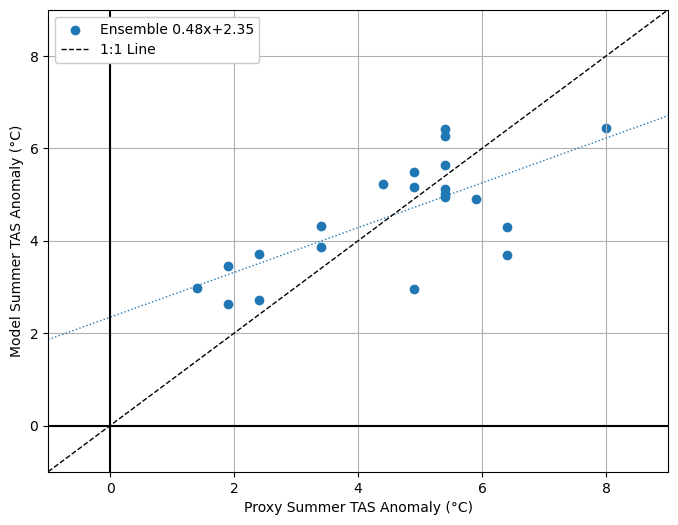

In [18]:

fig = plt.figure(figsize=(8,6))


m, b = np.polyfit(proxy_point_vals, ensemble_point_vals, 1)
x = np.array([-1,9])
y = m * x + b
plt.scatter(proxy_point_vals, ensemble_point_vals, label=f'Ensemble {m:.2f}x+{b:.2f}')
plt.plot(x, y, linestyle=':', linewidth=1)#, label=f'{model} Fit')

plt.xlabel('Proxy Summer TAS Anomaly (°C)')
plt.ylabel('Model Summer TAS Anomaly (°C)')
plt.axhline(0, color='k', linestyle='-', linewidth=1.5)
plt.axvline(0, color='k', linestyle='-', linewidth=1.5)
#make sure axes are equal
plt.xlim(-1,9)
plt.ylim(-1,9)

#plot 1:1 line
plt.plot([-1,9], [-1,9], color='k', linestyle='--', linewidth=1, label='1:1 Line')



plt.legend(loc='upper left', framealpha=1)
plt.grid()
plt.show()

In [19]:
def fit_weights_with_uncertainties(model_point_dict, proxy_point_vals, proxy_point_sd,
                                  sigma_floor=1e-6):
    """
    Fit ensemble weights w (one per model) to proxy data with 1σ uncertainties via
    constrained weighted least squares:
        minimize Σ_i ((Xw - y)_i^2 / σ_i^2)
        subject to w >= 0 and Σ w = 1

    Returns: (weights_dict, weighted_rmse, ensemble_vals)
    """
    model_names = list(model_point_dict.keys())
    X = np.column_stack([np.asarray(model_point_dict[m], dtype=float) for m in model_names])
    y = np.asarray(proxy_point_vals, dtype=float)
    s = np.asarray(proxy_point_sd, dtype=float)

    if X.shape[0] != y.shape[0] or y.shape[0] != s.shape[0]:
        raise ValueError(f"Length mismatch: X={X.shape[0]}, y={y.shape[0]}, sigma={s.shape[0]}")

    # Prevent divide-by-zero / over-dominant points
    s = np.maximum(s, sigma_floor)
    inv_var = 1.0 / (s * s)

    # Objective proportional to negative log-likelihood for independent Gaussian errors
    def w_sse(w):
        r = X @ w - y
        return np.sum(inv_var * r * r)

    M = X.shape[1]
    w0 = np.ones(M) / M

    constraints = [LinearConstraint(np.ones(M), lb=1.0, ub=1.0)]
    bounds = Bounds(lb=np.zeros(M), ub=np.ones(M))  # ub optional; sum-to-one makes it redundant

    res = minimize(
        w_sse,
        w0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"ftol": 1e-12, "maxiter": 50_000},
    )
    if not res.success:
        raise RuntimeError(f"Optimization failed: {res.message}")

    w = res.x
    ensemble = X @ w

    weighted_rmse = np.sqrt(np.sum(inv_var * (ensemble - y) ** 2) / np.sum(inv_var))
    weights = dict(zip(model_names, w))
    return weights, weighted_rmse, ensemble


In [20]:
weights_unc, rmse_unc, ensemble_vals_unc = fit_weights_with_uncertainties(model_point_dict, proxy_point_vals, point_sds)
print("RMSE:", rmse_unc)
print("Weights:")
for k, v in sorted(weights_unc.items(), key=lambda kv: kv[1], reverse=True):
    print(f"  {k:15s} {v:.4f}")

RMSE: 0.8787995326167176
Weights:
  CNRM-CM6-1      0.3762
  NESM3           0.2919
  EC-Earth3       0.1934
  HadGEM3-GC31-LL 0.1385
  ACCESS-ESM1-5   0.0000
  FGOALS-f3-L     0.0000
  FGOALS-g3       0.0000
  IPSL-CM6A-LR    0.0000


In [21]:
for k, v in sorted(weights_unc.items(), key=lambda kv: kv[1], reverse=True):
    print(f"'{k}':{v:.4f},")

'CNRM-CM6-1':0.3762,
'NESM3':0.2919,
'EC-Earth3':0.1934,
'HadGEM3-GC31-LL':0.1385,
'ACCESS-ESM1-5':0.0000,
'FGOALS-f3-L':0.0000,
'FGOALS-g3':0.0000,
'IPSL-CM6A-LR':0.0000,


In [22]:
#create ensemble using weights
ensemble_point_vals_unc = []
for model in models:
    weight = weights_unc[model]
    model_point_vals = model_point_dict[model]
    weighted_vals = [weight * val for val in model_point_vals]
    if not ensemble_point_vals_unc:
        ensemble_point_vals_unc = weighted_vals
    else:
        ensemble_point_vals_unc = [sum(x) for x in zip(ensemble_point_vals_unc, weighted_vals)]

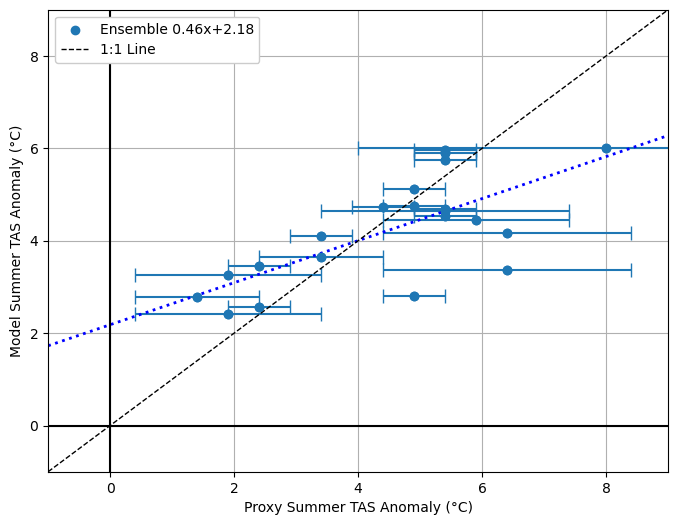

In [23]:
fig = plt.figure(figsize=(8,6))


m, b = np.polyfit(proxy_point_vals, ensemble_point_vals_unc, 1)
x = np.array([-1,9])
y = m * x + b
plt.scatter(proxy_point_vals, ensemble_point_vals_unc, label=f'Ensemble {m:.2f}x+{b:.2f}')
#add error bars
plt.errorbar(proxy_point_vals, ensemble_point_vals_unc, xerr=point_sds, fmt='o', linestyle='None', capsize=5)
plt.plot(x, y, linestyle=':', linewidth=2, color='blue')#, label=f'{model} Fit')

plt.xlabel('Proxy Summer TAS Anomaly (°C)')
plt.ylabel('Model Summer TAS Anomaly (°C)')
plt.axhline(0, color='k', linestyle='-', linewidth=1.5)
plt.axvline(0, color='k', linestyle='-', linewidth=1.5)
#make sure axes are equal
plt.xlim(-1,9)
plt.ylim(-1,9)

#plot 1:1 line
plt.plot([-1,9], [-1,9], color='k', linestyle='--', linewidth=1, label='1:1 Line')



plt.legend(loc='upper left', framealpha=1)
plt.grid()
plt.show()

In [24]:
def fit_weights_wls_with_mean_penalty(
    model_point_dict,
    proxy_point_vals,
    proxy_sigma_1s,
    lam=1.0,                 # strength of mean-matching penalty
    use_weighted_mean=True,  # mean computed with inverse-variance weights
    sigma_floor=1e-6
):
    #Minimise RMSE with penalty on ensemble mean deviating from proxy mean
    #RMSE is weighted by proxy uncertainties
    
    model_names = list(model_point_dict.keys())
    X = np.column_stack([np.asarray(model_point_dict[m], float) for m in model_names])
    y = np.asarray(proxy_point_vals, float)
    s = np.asarray(proxy_sigma_1s, float)

    if X.shape[0] != y.shape[0] or y.shape[0] != s.shape[0]:
        raise ValueError(f"Length mismatch: X={X.shape[0]}, y={y.shape[0]}, sigma={s.shape[0]}")

    s = np.maximum(s, sigma_floor)
    inv_var = 1.0 / (s * s)

    # Precompute mean operator
    if use_weighted_mean:
        a = inv_var / np.sum(inv_var)       # sums to 1
    else:
        a = np.ones_like(y) / y.size        # sums to 1

    mu_y = float(a @ y)

    def objective(w):
        r = X @ w - y
        wls = np.sum(inv_var * r * r)       # weighted SSE
        mu_ens = float(a @ (X @ w))
        mean_pen = lam * (mu_ens - mu_y) ** 2
        return wls + mean_pen

    M = X.shape[1]
    w0 = np.ones(M) / M

    constraints = [LinearConstraint(np.ones(M), lb=1.0, ub=1.0)]
    bounds = Bounds(lb=np.zeros(M), ub=np.ones(M))

    res = minimize(
        objective, w0, method="SLSQP",
        bounds=bounds, constraints=constraints,
        options={"ftol": 1e-12, "maxiter": 50_000},
    )
    if not res.success:
        raise RuntimeError(f"Optimization failed: {res.message}")

    w = res.x
    ensemble = X @ w
    weighted_rmse = np.sqrt(np.sum(inv_var * (ensemble - y) ** 2) / np.sum(inv_var))
    mean_bias = float((a @ ensemble) - mu_y)

    return dict(zip(model_names, w)), weighted_rmse, mean_bias, ensemble


In [25]:
for lam in [0, 0.1, 1, 10, 100, 1000]:
    weights, wrmse, mean_bias, _ = fit_weights_wls_with_mean_penalty(
        model_point_dict, proxy_point_vals, point_sds, lam=lam
    )
    print(lam, wrmse, mean_bias)

0 0.8787995326167176 0.0065242961414657685
0.1 0.8787995326944995 0.0065135526147726
1 0.8787995400367881 0.006418452854370038
10 0.8788000970475381 0.005600764434258387
100 0.8788104471679821 0.0024629669294986556
1000 0.8788245704532868 0.0003729924384767713


In [26]:
#order weights by size

for model, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
    print(f"'{model}':{weight:.4f},")   

'CNRM-CM6-1':0.3758,
'NESM3':0.2951,
'EC-Earth3':0.1932,
'HadGEM3-GC31-LL':0.1358,
'ACCESS-ESM1-5':0.0000,
'FGOALS-f3-L':0.0000,
'FGOALS-g3':0.0000,
'IPSL-CM6A-LR':0.0000,


In [27]:
def fit_wls_with_model_mean_prior(model_point_dict, proxy_point_vals, proxy_sigma_1s,
                                 alpha=1.0, use_weighted_mean=True, sigma_floor=1e-6):
    #Minimise RMSE, favouring models whose mean is close to the proxy mean
    #RMSE is weighted by proxy uncertainties
    model_names = list(model_point_dict.keys())
    X = np.column_stack([np.asarray(model_point_dict[m], float) for m in model_names])
    y = np.asarray(proxy_point_vals, float)
    s = np.asarray(proxy_sigma_1s, float)

    if X.shape[0] != y.shape[0] or y.shape[0] != s.shape[0]:
        raise ValueError("Length mismatch between X, y, and sigma.")

    s = np.maximum(s, sigma_floor)
    inv_var = 1.0 / (s * s)

    # Mean operator a: either inverse-variance-weighted or plain mean
    if use_weighted_mean:
        a = inv_var / np.sum(inv_var)     # sums to 1
    else:
        a = np.ones_like(y) / y.size

    mu_y = float(a @ y)
    mu_models = a @ X                    # shape (M,)
    d = mu_models - mu_y                 # mean mismatches per model

    def objective(w):
        r = X @ w - y
        wls = np.sum(inv_var * r * r)
        mean_prior = alpha * np.sum(w * (d * d))
        return wls + mean_prior

    M = X.shape[1]
    w0 = np.ones(M) / M

    constraints = [LinearConstraint(np.ones(M), lb=1.0, ub=1.0)]
    bounds = Bounds(lb=np.zeros(M), ub=np.ones(M))

    res = minimize(objective, w0, method="SLSQP", bounds=bounds, constraints=constraints,
                   options={"ftol": 1e-12, "maxiter": 50_000})
    if not res.success:
        raise RuntimeError(res.message)

    w = res.x
    ensemble = X @ w
    wrmse = np.sqrt(np.sum(inv_var * (ensemble - y) ** 2) / np.sum(inv_var))
    ens_mean_bias = float((a @ ensemble) - mu_y)

    return dict(zip(model_names, w)), wrmse, ens_mean_bias


In [28]:
for alpha in [0, 0.1, 1, 10]:
    weights, wrmse, mean_bias = fit_wls_with_model_mean_prior(
        model_point_dict, proxy_point_vals, point_sds, alpha=alpha
    )
    print(alpha, wrmse, mean_bias)

0 0.8787995326167176 0.0065242961414657685
0.1 0.8788043395085038 0.007330834281031429
1 0.8792800851968521 0.014589708399849854
10 0.938689010422261 0.09704437644353536


In [29]:
alpha = 1.0
weights, wrmse, mean_bias = fit_wls_with_model_mean_prior(
    model_point_dict, proxy_point_vals, point_sds, alpha=alpha
)
print("Final weights with model mean prior (alpha={}):".format(alpha))
for model, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
    print(f"'{model}':{weight:.4f},")   

Final weights with model mean prior (alpha=1.0):
'CNRM-CM6-1':0.4051,
'NESM3':0.2723,
'EC-Earth3':0.1831,
'HadGEM3-GC31-LL':0.1394,
'FGOALS-f3-L':0.0000,
'FGOALS-g3':0.0000,
'IPSL-CM6A-LR':0.0000,
'ACCESS-ESM1-5':0.0000,


In [30]:
from scipy.special import gammaln

In [31]:
def _log_dirichlet_pdf(w, alpha):
    # log Dirichlet(w | alpha), w on simplex
    # returns -inf if out of simplex
    if np.any(w <= 0) or not np.isfinite(w).all():
        return -np.inf
    s = np.sum(w)
    if not np.isclose(s, 1.0, atol=1e-10):
        return -np.inf
    alpha = np.asarray(alpha, float)
    return (gammaln(np.sum(alpha)) - np.sum(gammaln(alpha)) +
            np.sum((alpha - 1.0) * np.log(w)))

def _log_likelihood_gaussian(y, mu, sigma):
    r = (y - mu) / sigma
    # constant terms dropped (fine for MCMC ratios)
    return -0.5 * np.sum(r * r)

def sample_weights_dirichlet_mh(
    model_point_dict,
    proxy_point_vals,
    proxy_sigma_1s,
    alpha_dirichlet=1.0,
    sigma_rep=0.0,              # extra discrepancy term added in quadrature
    n_steps=200_000,
    burn=20_000,
    thin=20,
    proposal_conc=200.0,        # higher = smaller moves; tune for acceptance ~0.2–0.4
    random_seed=42,
):
    """
    Lightweight Metropolis-Hastings sampler on the simplex.

    Proposal: w' ~ Dirichlet(proposal_conc * w_current)
      (a "local" move on simplex; includes correct Hastings ratio)

    Returns:
      model_names, samples (n_samples x n_models), accept_rate
    """
    rng = np.random.default_rng(random_seed)

    model_names = list(model_point_dict.keys())
    X = np.column_stack([np.asarray(model_point_dict[m], float) for m in model_names])
    y = np.asarray(proxy_point_vals, float)
    s = np.asarray(proxy_sigma_1s, float)

    if X.shape[0] != y.shape[0] or y.shape[0] != s.shape[0]:
        raise ValueError(f"Length mismatch: X={X.shape[0]}, y={y.shape[0]}, sigma={s.shape[0]}")

    sigma_eff = np.sqrt(s * s + float(sigma_rep) ** 2)

    M = X.shape[1]
    if np.isscalar(alpha_dirichlet):
        alpha = np.full(M, float(alpha_dirichlet))
    else:
        alpha = np.asarray(alpha_dirichlet, float)
        if alpha.shape != (M,):
            raise ValueError(f"alpha_dirichlet must be scalar or shape (n_models,), got {alpha.shape}")

    # init at uniform
    w = np.ones(M) / M

    def logpost(w_):
        mu = X @ w_
        return _log_likelihood_gaussian(y, mu, sigma_eff) + _log_dirichlet_pdf(w_, alpha)

    lp = logpost(w)

    # store after burn-in and thinning
    kept = []
    accepted = 0

    for t in range(n_steps):
        # Dirichlet random-walk proposal centered at current w
        a_fwd = proposal_conc * w
        w_prop = rng.dirichlet(a_fwd)

        lp_prop = logpost(w_prop)

        # Hastings correction because proposal is asymmetric:
        # q(w'|w)=Dir(w'; conc*w), q(w|w')=Dir(w; conc*w')
        a_bwd = proposal_conc * w_prop
        log_q_fwd = _log_dirichlet_pdf(w_prop, a_fwd)
        log_q_bwd = _log_dirichlet_pdf(w, a_bwd)

        log_accept = (lp_prop - lp) + (log_q_bwd - log_q_fwd)

        if np.log(rng.random()) < log_accept:
            w = w_prop
            lp = lp_prop
            accepted += 1

        # record
        if t >= burn and ((t - burn) % thin == 0):
            kept.append(w.copy())

    samples = np.asarray(kept)
    accept_rate = accepted / n_steps
    return model_names, samples, accept_rate

def summarise_samples(model_names, samples, hdi_prob=0.95):
    """
    Simple posterior summary without arviz:
    mean, median, and equal-tail credible interval.
    """
    lo = (1 - hdi_prob) / 2
    hi = 1 - lo
    mean = samples.mean(axis=0)
    med = np.median(samples, axis=0)
    qlo = np.quantile(samples, lo, axis=0)
    qhi = np.quantile(samples, hi, axis=0)

    rows = []
    for i, name in enumerate(model_names):
        rows.append((name, mean[i], med[i], qlo[i], qhi[i]))
    rows.sort(key=lambda r: r[1], reverse=True)
    return rows


In [32]:
model_names, samples, acc = sample_weights_dirichlet_mh(
    model_point_dict,
    proxy_point_vals,
    proxy_sigma_1s=point_sds,
    alpha_dirichlet=0.5,   # 1.0 (uniform) or 2.0 (more even) or 0.5 (spikier)
    sigma_rep=0.1,         # optional but recommended to test (°C)
    proposal_conc=200.0,   # tune this
)
print("acceptance:", acc, "n_samples:", samples.shape[0])

summary = summarise_samples(model_names, samples, hdi_prob=0.95)
for name, mean, med, lo, hi in summary:
    print(f"{name:16s} mean={mean:6.3f} med={med:6.3f}  95% CI=({lo:6.3f},{hi:6.3f})")


acceptance: 0.2858 n_samples: 9000
CNRM-CM6-1       mean= 0.297 med= 0.286  95% CI=( 0.005, 0.661)
HadGEM3-GC31-LL  mean= 0.208 med= 0.199  95% CI=( 0.001, 0.499)
NESM3            mean= 0.178 med= 0.175  95% CI=( 0.001, 0.406)
EC-Earth3        mean= 0.155 med= 0.157  95% CI=( 0.042, 0.266)
FGOALS-f3-L      mean= 0.056 med= 0.032  95% CI=( 0.000, 0.228)
IPSL-CM6A-LR     mean= 0.046 med= 0.026  95% CI=( 0.000, 0.186)
FGOALS-g3        mean= 0.039 med= 0.021  95% CI=( 0.000, 0.169)
ACCESS-ESM1-5    mean= 0.020 med= 0.010  95% CI=( 0.000, 0.099)


In [33]:
for name, mean in sorted(zip(model_names, samples.mean(axis=0)), key=lambda x: x[1], reverse=True):
    print(f"'{name}':{mean:.4f},")

'CNRM-CM6-1':0.2972,
'HadGEM3-GC31-LL':0.2084,
'NESM3':0.1780,
'EC-Earth3':0.1555,
'FGOALS-f3-L':0.0562,
'IPSL-CM6A-LR':0.0457,
'FGOALS-g3':0.0388,
'ACCESS-ESM1-5':0.0202,


In [35]:
def _log_dirichlet_pdf(w, alpha):
    """Log Dirichlet density. Returns -inf outside simplex."""
    if np.any(w <= 0.0) or not np.isfinite(w).all():
        return -np.inf
    if not np.isclose(np.sum(w), 1.0, atol=1e-10):
        return -np.inf
    alpha = np.asarray(alpha, float)
    return (
        gammaln(np.sum(alpha))
        - np.sum(gammaln(alpha))
        + np.sum((alpha - 1.0) * np.log(w))
    )


def _loglike_gaussian_diag(resid, sigma):
    """
    Gaussian log-likelihood with diagonal covariance.
    Constant terms are omitted (OK for MH ratios).
    """
    z = resid / sigma
    return -0.5 * np.sum(z * z)


def sample_weights_two_block_dirichlet_mh(
    model_temp_dict,
    proxy_temp_vals,
    proxy_temp_sd,
    model_sia_dict,
    proxy_sia_val,
    proxy_sia_sd,
    alpha_dirichlet=1.0,
    sigma_rep_temp=0.0,
    sigma_rep_sia=0.0,
    n_steps=200_000,
    burn=20_000,
    thin=20,
    proposal_conc=200.0,
    seed=42,
):
    """
    Posterior over model weights w on the simplex using:
      - Temperature block likelihood (N_T points)
      - SIA scalar likelihood (1 point)
      - Two-block combination giving equal weight to the temp block and SIA block:
            logL = 0.5*(1/N_T)*logL_T + 0.5*logL_SIA
      - Dirichlet prior w ~ Dir(alpha)

    Inputs:
      model_temp_dict: {model: [T_i,m for i=1..N_T]}
      proxy_temp_vals: length N_T
      proxy_temp_sd: length N_T (1-sigma)
      model_sia_dict: {model: A_m}
      proxy_sia_val: scalar
      proxy_sia_sd: scalar (1-sigma)
      sigma_rep_temp/sia: optional mismatch terms added in quadrature

    Returns:
      model_names, samples (n_samples x n_models), accept_rate
    """

    rng = np.random.default_rng(seed)

    # --- align models across both dicts ---
    models_temp = set(model_temp_dict.keys())
    models_sia = set(model_sia_dict.keys())
    model_names = sorted(models_temp.intersection(models_sia))
    if len(model_names) == 0:
        raise ValueError("No overlapping model names between model_temp_dict and model_sia_dict.")

    # --- build arrays ---
    X_T = np.column_stack([np.asarray(model_temp_dict[m], dtype=float) for m in model_names])  # (N_T, M)
    y_T = np.asarray(proxy_temp_vals, dtype=float)
    s_T = np.asarray(proxy_temp_sd, dtype=float)

    if X_T.shape[0] != y_T.shape[0] or y_T.shape[0] != s_T.shape[0]:
        raise ValueError(f"Temp length mismatch: X_T={X_T.shape[0]}, y_T={y_T.shape[0]}, sd_T={s_T.shape[0]}")

    N_T, M = X_T.shape

    x_A = np.asarray([model_sia_dict[m] for m in model_names], dtype=float)  # (M,)
    y_A = float(proxy_sia_val)
    s_A = float(proxy_sia_sd)

    # effective sigmas (add representation error in quadrature)
    s_T_eff = np.sqrt(s_T**2 + float(sigma_rep_temp)**2)
    s_A_eff = np.sqrt(s_A**2 + float(sigma_rep_sia)**2)

    # Dirichlet prior parameters
    if np.isscalar(alpha_dirichlet):
        alpha = np.full(M, float(alpha_dirichlet))
    else:
        alpha = np.asarray(alpha_dirichlet, dtype=float)
        if alpha.shape != (M,):
            raise ValueError(f"alpha_dirichlet must be scalar or shape (n_models,), got {alpha.shape}")

    # --- define log posterior up to constant ---
    def log_posterior(w):
        # temperature predictions
        mu_T = X_T @ w  # (N_T,)
        logL_T = _loglike_gaussian_diag(y_T - mu_T, s_T_eff)

        # sia prediction
        mu_A = float(x_A @ w)
        logL_A = _loglike_gaussian_diag(np.array([y_A - mu_A]), np.array([s_A_eff]))

        # two-block combination (equal weight for temp block and SIA block)
        logL = 0.5 * (logL_T / N_T) + 0.5 * logL_A

        # prior
        logP = _log_dirichlet_pdf(w, alpha)
        return logL + logP

    # --- MCMC: Dirichlet random-walk Metropolis-Hastings ---
    w = np.ones(M) / M
    lp = log_posterior(w)

    accepted = 0
    kept = []

    for t in range(n_steps):
        a_fwd = proposal_conc * w
        w_prop = rng.dirichlet(a_fwd)

        lp_prop = log_posterior(w_prop)

        # Hastings correction for asymmetric Dirichlet proposals
        a_bwd = proposal_conc * w_prop
        log_q_fwd = _log_dirichlet_pdf(w_prop, a_fwd)
        log_q_bwd = _log_dirichlet_pdf(w, a_bwd)

        log_accept = (lp_prop - lp) + (log_q_bwd - log_q_fwd)

        if np.log(rng.random()) < log_accept:
            w = w_prop
            lp = lp_prop
            accepted += 1

        if t >= burn and ((t - burn) % thin == 0):
            kept.append(w.copy())

    samples = np.asarray(kept)
    accept_rate = accepted / n_steps
    return model_names, samples, accept_rate


def summarise_weight_samples(model_names, samples, ci=0.95):
    """Posterior mean/median + equal-tail CI (no arviz needed)."""
    lo = (1 - ci) / 2
    hi = 1 - lo
    mean = samples.mean(axis=0)
    median = np.median(samples, axis=0)
    qlo = np.quantile(samples, lo, axis=0)
    qhi = np.quantile(samples, hi, axis=0)
    rows = [(model_names[i], mean[i], median[i], qlo[i], qhi[i]) for i in range(len(model_names))]
    return sorted(rows, key=lambda r: r[1], reverse=True)


In [ ]:
model_sia_dict = {'ACCESS-ESM1-5': 1.4188107321502381, 
                    'CNRM-CM6-1': 2.4279139845011755, 
                    'EC-Earth3': 0.5825733238075962, 
                    'FGOALS-f3-L': 1.2790425538170256, 
                    'FGOALS-g3': 2.674778099305233,
                    'HadGEM3-GC31-LL': 0.31988712,
                    'IPSL-CM6A-LR': 2.338705398142338, 
                    'NESM3': 2.0560369961278413}

proxy_sia_val = 1.0
proxy_sia_sd = 0.5

acceptance rate: 0.116705
HadGEM3-GC31-LL  mean= 0.284 med= 0.233  95% CI=( 0.000, 0.785)
CNRM-CM6-1       mean= 0.131 med= 0.037  95% CI=( 0.000, 0.704)
FGOALS-f3-L      mean= 0.127 med= 0.043  95% CI=( 0.000, 0.592)
EC-Earth3        mean= 0.113 med= 0.020  95% CI=( 0.000, 0.573)
IPSL-CM6A-LR     mean= 0.109 med= 0.032  95% CI=( 0.000, 0.629)
ACCESS-ESM1-5    mean= 0.101 med= 0.053  95% CI=( 0.000, 0.541)
NESM3            mean= 0.071 med= 0.018  95% CI=( 0.000, 0.432)
FGOALS-g3        mean= 0.064 med= 0.021  95% CI=( 0.000, 0.345)


In [ ]:
model_names, samples, acc = sample_weights_two_block_dirichlet_mh(
    model_temp_dict=model_point_dict,
    proxy_temp_vals=proxy_point_vals,
    proxy_temp_sd=point_sds,          # <-- your 21-element 1σ list/array
    model_sia_dict=model_sia_dict,
    proxy_sia_val=proxy_sia_val,
    proxy_sia_sd=proxy_sia_sd,
    alpha_dirichlet=0.25,                  #1 = neutral, <1 = spikier (more weight in a few models), >1 = smoother
    sigma_rep_temp=0.0,                   # optional
    sigma_rep_sia=0.0,                    # optional
    proposal_conc=200.0,
)


print("acceptance rate:", acc)
summary = summarise_weight_samples(model_names, samples, ci=0.95)
for name, mean, med, lo, hi in summary:
    print(f"{name:16s} mean={mean:6.3f} med={med:6.3f}  95% CI=({lo:6.3f},{hi:6.3f})")

In [44]:
for name, mean, med, lo, hi in summary:
    print(f"'{name}':{mean:.4f},")

'HadGEM3-GC31-LL':0.2840,
'CNRM-CM6-1':0.1309,
'FGOALS-f3-L':0.1272,
'EC-Earth3':0.1126,
'IPSL-CM6A-LR':0.1092,
'ACCESS-ESM1-5':0.1010,
'NESM3':0.0714,
'FGOALS-g3':0.0636,


In [ ]:

#save model_point_dict to a pickle file
with open('model_point_dict.pkl', 'wb') as f:
    pickle.dump(model_point_dict, f)

In [37]:
def notify(msg, BOT_TOKEN, CHAT_ID):
    url = f"https://api.telegram.org/bot{BOT_TOKEN}/sendMessage"
    requests.post(
        url,
        data={
            "chat_id": CHAT_ID,
            "text": msg,
            "parse_mode": "Markdown"
        },
        timeout=10
    )

In [38]:

#Chat id is found at https://api.telegram.org/bot<YourBOTToken>/getUpdates

def load_secrets(path):
    secrets = {}
    with open(path) as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            key, val = line.split("=", 1)
            secrets[key] = val
    return secrets

secrets = load_secrets(Path.home() / ".secrets" / "telegram.txt")

BOT_TOKEN = secrets["TG_BOT_TOKEN"]
CHAT_ID = secrets["TG_CHAT_ID"]

In [39]:

notify(f'Finished calculating RMSE-weighted ensemble. RMSE: {rmse:.2f} °C', BOT_TOKEN, CHAT_ID)
